In [1]:
import arcpy
from arcpy import env
import os
import numpy as np
from arcgis import GIS
from arcgis.features import GeoAccessor
from arcgis.features import GeoSeriesAccessor
import pandas as pd

arcpy.env.overwriteOutput = True
arcpy.env.parallelProcessingFactor = "90%"

# show all columns
pd.options.display.max_columns = None

# pd.pivot_table(df, values='a', index='b', columns='c', aggfunc='sum', fill_value=0)
# pd.DataFrame.spatial.from_featureclass(???)  
# df.spatial.to_featureclass(location=???,sanitize_columns=False)  

# gsa = arcgis.features.GeoSeriesAccessor(df['SHAPE'])  
# df['AREA'] = gsa.area  # KNOW YOUR UNITS

In [2]:
# fill NA values in Spatially enabled dataframes (ignores SHAPE column)
def fill_na_sedf(df_with_shape_column, fill_value=0):
    if 'SHAPE' in list(df_with_shape_column.columns):
        df = df_with_shape_column.copy()
        shape_column = df['SHAPE'].copy()
        del df['SHAPE']
        return df.fillna(fill_value).merge(shape_column,left_index=True, right_index=True, how='inner')
    else:
        raise Exception("Dataframe does not include 'SHAPE' column")

In [3]:
if not os.path.exists('Outputs'):
    os.makedirs('Outputs')
    
outputs = ['.\\Outputs', "scratch.gdb", 'hui_for_web.gdb']
gdb = os.path.join(outputs[0], outputs[1])
gdb2 = os.path.join(outputs[0], outputs[2])

if not arcpy.Exists(gdb):
    arcpy.CreateFileGDB_management(outputs[0], outputs[1])

if not arcpy.Exists(gdb2):
    arcpy.CreateFileGDB_management(outputs[0], outputs[2])

In [2]:
hui= r'.\inputs\housing_unit_inventory_2022.gdb\housing_unit_inventory_2022'
t = r'.\inputs\Stations_Interchanges.gdb\Interchanges_and_Stations'
t_lyr = arcpy.MakeFeatureLayer_management(t, 't_lyr')
parks = r".\inputs\wcv_parks.shp"
trails = r".\inputs\TrailsAndPathways_WFRCMAG.shp"
centers = r"E:\Data\Boundaries\WC2050Centers.shp"

In [5]:
# use spatial join to summarize h+t
target_features = hui
join_features = centers
output_features = os.path.join(gdb, "_00_hui_center_sj")

fieldmappings = arcpy.FieldMappings()
fieldmappings.addTable(target_features)
fieldmappings.addTable(join_features)

fields = ['AreaName']
for f in fields:

# field
    fieldindex = fieldmappings.findFieldMapIndex(f)
    fieldmap = fieldmappings.getFieldMap(fieldindex)
    fieldmap.mergeRule = 'first'
    fieldmappings.replaceFieldMap(fieldindex, fieldmap)

# run the spatial join
sj = arcpy.SpatialJoin_analysis(target_features, join_features, output_features,'JOIN_ONE_TO_ONE', "KEEP_COMMON", 
                           fieldmappings, "HAVE_THEIR_CENTER_IN")

In [6]:
sj_df = pd.DataFrame.spatial.from_featureclass(sj[0])
sj_df.head()

,OBJECTID,Join_Count,TARGET_FID,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,BLT_YR2,OBJECTID_1,AreaName,AreaType,Area,SHAPE_Leng,SHAPE
0,1,1,2,2.0,multi_family,apartment,0,7.0,76.03,0.092074,7996.0,2122800.0,1911.0,1910,Salt Lake City,Salt Lake,North Salt Lake County,1911-01-01,460,University Gardens,Neighborhood Center,WFRC MPO,2351.398183,"{""rings"": [[[427903.33660000004, 4513458.2684]..."
1,2,1,11,11.0,multi_family,apartment,0,4.0,17.68,0.226250,2067.0,710000.0,1981.0,1980,Ogden,Weber,South Weber County,1981-01-01,337,Five Points,City Center,WFRC MPO,14189.274973,"{""rings"": [[[418951.6300999997, 4569306.7969],..."
2,3,1,12,12.0,single_family,single_family,1,6.0,4.51,1.331129,32340.0,7231900.0,1997.0,1990,Holladay,Salt Lake,Southeast Salt Lake County,1997-01-01,510,Holladay City Center,City Center,WFRC MPO,9127.615298,"{""rings"": [[[430406.1229999997, 4502550.6117],..."
3,4,1,31,31.0,multi_family,duplex,0,4.0,10.71,0.373328,2038.0,254000.0,1944.0,1940,Sunset,Davis,North Davis County,1944-01-01,315,Sunset SR 126,City Center,WFRC MPO,13882.491846,"{""rings"": [[[413809.55709999986, 4554702.51679..."
4,5,1,46,46.0,multi_family,apartment,0,10.0,44.68,0.223795,5264.0,1971200.0,1965.0,1960,Salt Lake City,Salt Lake,North Salt Lake County,1965-01-01,504,Salt Lake City East Downtown,Urban Center,WFRC MPO,6179.798990,"{""rings"": [[[425972.3041000003, 4512195.274900..."


In [7]:
sj_df = sj_df[['UNIT_ID', 'AreaName', 'AreaType']].copy()
sj_df.columns = ['UNIT_ID', 'CENTER', 'CENTERTYPE']

In [8]:
name = 'parks'
# copy = arcpy.conversion.FeatureClassToFeatureClass(hui, gdb, f'hui_near_{name}')
# near_result = arcpy.analysis.Near(in_features=copy, near_features=parks, method='GEODESIC')
# df_parks = pd.DataFrame.spatial.from_featureclass(near_result[0])
df_parks = pd.DataFrame.spatial.from_featureclass(os.path.join(gdb, f'hui_near_{name}'))
df_parks.head()

,OBJECTID,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,BLT_YR2,NEAR_FID,NEAR_DIST,SHAPE
0,1,1.0,multi_family,apartment,0,2.0,6.17,0.323897,2448.0,377500.0,1956.0,1950,West Valley City,Salt Lake,North Salt Lake County,1956-01-01,1065,403.798447,"{""rings"": [[[418293.5917999996, 4504696.102499..."
1,2,2.0,multi_family,apartment,0,7.0,76.03,0.092074,7996.0,2122800.0,1911.0,1910,Salt Lake City,Salt Lake,North Salt Lake County,1911-01-01,1207,27.224699,"{""rings"": [[[427903.33660000004, 4513458.2684]..."
2,3,3.0,multi_family,duplex,0,2.0,14.82,0.134912,2551.0,675800.0,1909.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1909-01-01,1171,214.736461,"{""rings"": [[[426691.9088000003, 4510717.034499..."
3,4,4.0,multi_family,duplex,0,2.0,14.53,0.137643,2004.0,772200.0,1906.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1906-01-01,1152,233.978571,"{""rings"": [[[427077.60759999976, 4510787.9844]..."
4,5,5.0,multi_family,apartment,0,5.0,31.96,0.156440,2688.0,722800.0,1963.0,1960,Salt Lake City,Salt Lake,North Salt Lake County,1963-01-01,1217,310.382423,"{""rings"": [[[426023.3869000003, 4514349.822799..."


In [9]:
name = 'trails'
# copy = arcpy.conversion.FeatureClassToFeatureClass(hui, gdb, f'hui_near_{name}')
# near_result = arcpy.analysis.Near(in_features=copy, near_features=trails, method='GEODESIC')
# df_trails = pd.DataFrame.spatial.from_featureclass(near_result[0])
df_trails = pd.DataFrame.spatial.from_featureclass(os.path.join(gdb, f'hui_near_{name}'))
df_trails.head()

,OBJECTID,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,BLT_YR2,NEAR_FID,NEAR_DIST,SHAPE
0,1,1.0,multi_family,apartment,0,2.0,6.17,0.323897,2448.0,377500.0,1956.0,1950,West Valley City,Salt Lake,North Salt Lake County,1956-01-01,10936,379.741813,"{""rings"": [[[418293.5917999996, 4504696.102499..."
1,2,2.0,multi_family,apartment,0,7.0,76.03,0.092074,7996.0,2122800.0,1911.0,1910,Salt Lake City,Salt Lake,North Salt Lake County,1911-01-01,12145,356.360891,"{""rings"": [[[427903.33660000004, 4513458.2684]..."
2,3,3.0,multi_family,duplex,0,2.0,14.82,0.134912,2551.0,675800.0,1909.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1909-01-01,11674,239.491814,"{""rings"": [[[426691.9088000003, 4510717.034499..."
3,4,4.0,multi_family,duplex,0,2.0,14.53,0.137643,2004.0,772200.0,1906.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1906-01-01,11659,240.502276,"{""rings"": [[[427077.60759999976, 4510787.9844]..."
4,5,5.0,multi_family,apartment,0,5.0,31.96,0.156440,2688.0,722800.0,1963.0,1960,Salt Lake City,Salt Lake,North Salt Lake County,1963-01-01,12493,725.318570,"{""rings"": [[[426023.3869000003, 4514349.822799..."


In [10]:
name = 'frontrunner'
copy = arcpy.conversion.FeatureClassToFeatureClass(hui, gdb, f'hui_near_{name}')
arcpy.SelectLayerByAttribute_management(t_lyr, 'NEW_SELECTION', "SubMode = 'Commuter Rail Station' AND Status = 'Current'")
near_result = arcpy.analysis.Near(in_features=copy, near_features=t_lyr, method='GEODESIC')
df_fr = pd.DataFrame.spatial.from_featureclass(near_result[0])
df_fr = pd.DataFrame.spatial.from_featureclass(os.path.join(gdb, f'hui_near_{name}'))
df_fr.head()

,OBJECTID,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,BLT_YR2,NEAR_FID,NEAR_DIST,SHAPE
0,1,1.0,multi_family,apartment,0,2.0,6.17,0.323897,2448.0,377500.0,1956.0,1950,West Valley City,Salt Lake,North Salt Lake County,1956-01-01,441,6739.230717,"{""rings"": [[[418293.5917999996, 4504696.102499..."
1,2,2.0,multi_family,apartment,0,7.0,76.03,0.092074,7996.0,2122800.0,1911.0,1910,Salt Lake City,Salt Lake,North Salt Lake County,1911-01-01,445,4305.227021,"{""rings"": [[[427903.33660000004, 4513458.2684]..."
2,3,3.0,multi_family,duplex,0,2.0,14.82,0.134912,2551.0,675800.0,1909.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1909-01-01,444,3942.580203,"{""rings"": [[[426691.9088000003, 4510717.034499..."
3,4,4.0,multi_family,duplex,0,2.0,14.53,0.137643,2004.0,772200.0,1906.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1906-01-01,444,4277.714860,"{""rings"": [[[427077.60759999976, 4510787.9844]..."
4,5,5.0,multi_family,apartment,0,5.0,31.96,0.156440,2688.0,722800.0,1963.0,1960,Salt Lake City,Salt Lake,North Salt Lake County,1963-01-01,445,2433.646047,"{""rings"": [[[426023.3869000003, 4514349.822799..."


In [11]:
name = 'lightrail'
copy = arcpy.conversion.FeatureClassToFeatureClass(hui, gdb, f'hui_near_{name}')
arcpy.SelectLayerByAttribute_management(t_lyr, 'NEW_SELECTION', "SubMode = 'Light Rail Station' AND Status = 'Current'")
near_result = arcpy.analysis.Near(in_features=copy, near_features=t_lyr, method='GEODESIC')
df_lr = pd.DataFrame.spatial.from_featureclass(near_result[0])
df_lr = pd.DataFrame.spatial.from_featureclass(os.path.join(gdb, f'hui_near_{name}'))
df_lr.head()

,OBJECTID,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,BLT_YR2,NEAR_FID,NEAR_DIST,SHAPE
0,1,1.0,multi_family,apartment,0,2.0,6.17,0.323897,2448.0,377500.0,1956.0,1950,West Valley City,Salt Lake,North Salt Lake County,1956-01-01,408,875.847483,"{""rings"": [[[418293.5917999996, 4504696.102499..."
1,2,2.0,multi_family,apartment,0,7.0,76.03,0.092074,7996.0,2122800.0,1911.0,1910,Salt Lake City,Salt Lake,North Salt Lake County,1911-01-01,365,1038.100232,"{""rings"": [[[427903.33660000004, 4513458.2684]..."
2,3,3.0,multi_family,duplex,0,2.0,14.82,0.134912,2551.0,675800.0,1909.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1909-01-01,364,1831.938257,"{""rings"": [[[426691.9088000003, 4510717.034499..."
3,4,4.0,multi_family,duplex,0,2.0,14.53,0.137643,2004.0,772200.0,1906.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1906-01-01,364,1770.330078,"{""rings"": [[[427077.60759999976, 4510787.9844]..."
4,5,5.0,multi_family,apartment,0,5.0,31.96,0.156440,2688.0,722800.0,1963.0,1960,Salt Lake City,Salt Lake,North Salt Lake County,1963-01-01,377,1531.881722,"{""rings"": [[[426023.3869000003, 4514349.822799..."


In [12]:
name = 'brt'
copy = arcpy.conversion.FeatureClassToFeatureClass(hui, gdb, f'hui_near_{name}')
arcpy.SelectLayerByAttribute_management(t_lyr, 'NEW_SELECTION', "SubMode = 'BRT Stop' AND Status = 'Current'")
near_result = arcpy.analysis.Near(in_features=copy, near_features=t_lyr, method='GEODESIC')
df_brt = pd.DataFrame.spatial.from_featureclass(near_result[0])
df_brt = pd.DataFrame.spatial.from_featureclass(os.path.join(gdb, f'hui_near_{name}'))
df_brt.head()

,OBJECTID,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,BLT_YR2,NEAR_FID,NEAR_DIST,SHAPE
0,1,1.0,multi_family,apartment,0,2.0,6.17,0.323897,2448.0,377500.0,1956.0,1950,West Valley City,Salt Lake,North Salt Lake County,1956-01-01,535,49696.836770,"{""rings"": [[[418293.5917999996, 4504696.102499..."
1,2,2.0,multi_family,apartment,0,7.0,76.03,0.092074,7996.0,2122800.0,1911.0,1910,Salt Lake City,Salt Lake,North Salt Lake County,1911-01-01,535,55280.842138,"{""rings"": [[[427903.33660000004, 4513458.2684]..."
2,3,3.0,multi_family,duplex,0,2.0,14.82,0.134912,2551.0,675800.0,1909.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1909-01-01,535,52844.789365,"{""rings"": [[[426691.9088000003, 4510717.034499..."
3,4,4.0,multi_family,duplex,0,2.0,14.53,0.137643,2004.0,772200.0,1906.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1906-01-01,535,52795.318098,"{""rings"": [[[427077.60759999976, 4510787.9844]..."
4,5,5.0,multi_family,apartment,0,5.0,31.96,0.156440,2688.0,722800.0,1963.0,1960,Salt Lake City,Salt Lake,North Salt Lake County,1963-01-01,535,56488.192172,"{""rings"": [[[426023.3869000003, 4514349.822799..."


In [13]:
name = 'fwyexit'
copy = arcpy.conversion.FeatureClassToFeatureClass(hui, gdb, f'hui_near_{name}')
arcpy.SelectLayerByAttribute_management(t_lyr, 'NEW_SELECTION', "SubMode = 'Interchange' AND Status = 'Current'")
near_result = arcpy.analysis.Near(in_features=copy, near_features=t_lyr, method='GEODESIC')
df_fwy = pd.DataFrame.spatial.from_featureclass(near_result[0])
df_fwy = pd.DataFrame.spatial.from_featureclass(os.path.join(gdb, f'hui_near_{name}'))
df_fwy.head()

,OBJECTID,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,BLT_YR2,NEAR_FID,NEAR_DIST,SHAPE
0,1,1.0,multi_family,apartment,0,2.0,6.17,0.323897,2448.0,377500.0,1956.0,1950,West Valley City,Salt Lake,North Salt Lake County,1956-01-01,189,1474.367799,"{""rings"": [[[418293.5917999996, 4504696.102499..."
1,2,2.0,multi_family,apartment,0,7.0,76.03,0.092074,7996.0,2122800.0,1911.0,1910,Salt Lake City,Salt Lake,North Salt Lake County,1911-01-01,280,4861.577463,"{""rings"": [[[427903.33660000004, 4513458.2684]..."
2,3,3.0,multi_family,duplex,0,2.0,14.82,0.134912,2551.0,675800.0,1909.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1909-01-01,170,2819.211089,"{""rings"": [[[426691.9088000003, 4510717.034499..."
3,4,4.0,multi_family,duplex,0,2.0,14.53,0.137643,2004.0,772200.0,1906.0,1900,Salt Lake City,Salt Lake,North Salt Lake County,1906-01-01,169,2896.111816,"{""rings"": [[[427077.60759999976, 4510787.9844]..."
4,5,5.0,multi_family,apartment,0,5.0,31.96,0.156440,2688.0,722800.0,1963.0,1960,Salt Lake City,Salt Lake,North Salt Lake County,1963-01-01,187,2944.450384,"{""rings"": [[[426023.3869000003, 4514349.822799..."


In [14]:
# convert distance from meters to miles
df_fr['DIST_FR'] = df_fr['NEAR_DIST']*.000621371
df_lr['DIST_LR'] = df_lr['NEAR_DIST']*.000621371
df_brt['DIST_BRT'] = df_brt['NEAR_DIST']*.000621371
df_fwy['DIST_FWYE'] = df_fwy['NEAR_DIST']*.000621371
df_parks['DIST_PARK'] = df_parks['NEAR_DIST']*.000621371
df_trails['DIST_TRAIL'] = df_trails['NEAR_DIST']*.000621371

df_fr['DIST_FR'] = round(df_fr['DIST_FR'], 2)
df_lr['DIST_LR'] = round(df_lr['DIST_LR'], 2)
df_brt['DIST_BRT'] = round(df_brt['DIST_BRT'], 2)
df_fwy['DIST_FWYE'] = round(df_fwy['DIST_FWYE'], 2)
df_parks['DIST_PARK'] = round(df_parks['DIST_PARK'], 2)
df_trails['DIST_TRAIL'] = round(df_trails['DIST_TRAIL'], 2)

df_fr = df_fr[['UNIT_ID', 'DIST_FR']].copy()
df_lr = df_lr[['UNIT_ID', 'DIST_LR']].copy()
df_brt = df_brt[['UNIT_ID', 'DIST_BRT']].copy()
df_fwy = df_fwy [['UNIT_ID', 'DIST_FWYE']].copy()
df_parks = df_parks[['UNIT_ID', 'DIST_PARK']].copy()
df_trails = df_trails[['UNIT_ID', 'DIST_TRAIL']].copy()

In [15]:
hui_df = pd.DataFrame.spatial.from_featureclass(hui)
hui_df = (hui_df.merge(sj_df, on='UNIT_ID', how='left') 
                .merge(df_fr, on='UNIT_ID', how='left') 
                .merge(df_lr, on='UNIT_ID', how='left')  
                .merge(df_brt, on='UNIT_ID', how='left')
                .merge(df_fwy, on='UNIT_ID', how='left')
                .merge(df_parks, on='UNIT_ID', how='left')
                .merge(df_trails, on='UNIT_ID', how='left')) 

# hui_sf = hui_df[hui_df['TYPE']== 'single_family'].copy()
# hui_mf = hui_df[hui_df['TYPE']!= 'single_family'].copy()

# hui_df2 = pd.concat([hui_sf, hui_mf])
hui_df.spatial.to_featureclass(location=os.path.join(gdb2, 'hui_2022_web_version'),sanitize_columns=False)

'e:\\Projects\\Housing-Unit-Inventory-Explorer\\python\\Outputs\\hui_for_web.gdb\\hui_2022_web_version'

In [16]:
arcpy.management.FeatureToPoint(os.path.join(gdb2, 'hui_2022_web_version'), os.path.join(gdb2, 'hui_2022_pts_web_version'), "INSIDE")

<Result '.\\Outputs\\hui_for_web.gdb\\hui_2022_pts_web_version'>

# exploration

In [3]:
hui_df = pd.DataFrame.spatial.from_featureclass(hui)

array([[<AxesSubplot:title={'center':'DUA'}>]], dtype=object)

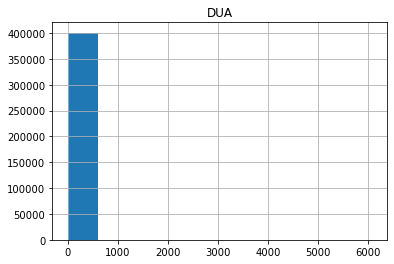

In [4]:
hui_df.hist(column='DUA')